# Interatomic force field (IFF) optimization for W-based metal alloys

Author: Lukas Vlcek

Start Date: 2018-04-22

In [1]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-11-12 13:27:38.145026


# Table of Contents

* [1. Introduction](#1.-Introduction)
* [2. Theoretical background](#2.-Theoretical-background)
    * [2.1 Model definition](#2.1-Model-definition)
    * [2.2 Optimization approach](#2.2-Optimization-approach)
        * [2.2.1 Perturbation technique](#2.2.1-Perturbation-technique)
        * [2.2.2 Statistical distance loss function](#2.2.2-Statistical-distance-loss-function)
    * [2.3 Target data](#2.3-Target-data)
    * [2.4 Simulation details](#2.4-Simulation-details)
* [3. Optimization](#3.-Optimization)

**Notebook setup**

In [2]:
# Import libraries
%matplotlib inline
import os
import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import h5py
from itertools import product
from scipy.optimize import fmin

# Paths to important directories
pot_path = '../sim/potentials'
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

## 1. Introduction

**Goal:** Optimize EAM potential for W using the functional form of Bonny et al. (2017), and target data from Marinica et al. (2013) and German. Show that using this simplified EAM form we can develop a more predictive model of W compared to EAM2 model of Marinica.

## 2. Theoretical background

### 2.1 Model definition

**Equilibrium potential**

Energy of an N-particle configuration

$$ E = \sum_{i=1}^N \left[ \sum_{j>i}^N V_{t_it_j}\left(r_{ij}\right) + F_{t_i}\left(\rho_i\right) \right] $$

Here $V_{t_it_j}$ is pair interaction between atom types $t_i$ and $t_j$ at distance $r_{ij}$ defined as

$$ V_{t_it_j}\left(r_{ij}\right) = \sum_{k=1}^{K}\left[a_k\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ $$

where $\Theta$ is Heaviside step function.
$F_{t_i}$ is the manybody embedding function

$$ F_{t_i}(\rho_i) = A_{t_i}\sqrt{\rho_i} + B_{t_i}\rho + C_{t_i}\rho^2 $$

where $\rho_i$ effective electron density 

$$ \rho_i = \sum_{j\ne i}^N \phi_{t_j}\left(r_{ij}\right) $$

and $\phi$ is cohesive potential

$$ \phi\left(r_{ij}\right) = D_{t_j}\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right) $$

In [3]:
# Define the equilibrium EAM functions (to be optimized)

# Pair potential (cubic splines). Parameters: distance (r), spline parameters (aa), spline nodes (cc)
V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

**Core and transition potential for short and intermediate distances**

In [4]:
#%%writefile -a ../../statmechlib/statmechlib/read_write/write_eam_lammps.py

# Define the core and transition parts of the potential (kept constant)
def u_core(r, za=74, zb=74):
    """Repulsive potential of the atomic cores. Default atomic numbers for W"""
    qe_sq = 14.3992 # squared electron charge  
    rs = 0.4683766/(za**(2/3) + zb**(2/3))**0.5
    x = r/rs
    u  = 0.1818*np.exp(-3.2*x)
    u += 0.5099*np.exp(-0.9423*x)
    u += 0.2802*np.exp(-0.4029*x)
    u += 0.02817*np.exp(-0.2016*x)
    u *= za*zb*qe_sq/r
    return u

def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq    

### 2.2 Optimization approach

#### 2.2.1 Perturbation technique

**EAM sufficient statistics**

**Energy of a configuration**

Energy of an N-particle configuration

$$ E_{pair} = \sum_{k=1}^{K}a_k\sum_{i=1}^N \sum_{j>i}^N \left[\left(r_k - r_{ij}\right)^3\Theta\left(r_k - r_{ij}\right)\right]\ = \sum_{k=1}^{K}a_kv_k $$

$$ E_{manybody} = b_1\sum_{i=1}^N\sqrt{\sum_{j\ne i}^N \left[\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right)\right]} + b_2 \sum_{i=1}^N \left( \sum_{j\ne i}^N \left[\left(r_c - r_{ij}\right)^3\Theta\left(r_c - r_{ij}\right)\right] \right)^2 = b_1m_1 + b_2m_2$$

**Similar for evaluating forces on each atom... **

During optimization, collect statistics $v_k$ and $b_k$ for each configuration and calculate its energy by multiplying them by model parameters $a_k$ and $b_k$.

In [5]:
#%%writefile ../../statmechlib/statmechlib/preprocessing/pair_dist.py

# pair distances between system atoms
def pair_dist(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : scalar or numpy array
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)

    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5*box, dp + box, dp)
            dp = np.where(dp >  0.5*box, dp - box, dp)
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp

    return rr, rx

In [6]:
#%%writefile -a ../../statmechlib/statmechlib/preprocessing/pair_dist.py
def pair_dist_triclinic(xyz, box):
    """
    Calculates nearest image pair distances between all atoms in xyz array.
    Parameters
    -----------
    xyz : numpy array
          particle x, y, z coordinates
    box : numpy 2D array of unit cell vectors or a float
          simulation box dimensions/shape
    Returns
    -------
    rr  : (natom, natom) numpy array of pair distances
    rx  : (natom, natom, 3) numpy array of pair distance coordinates
    """
    
    # make sure that the box is a 3x3 matrix (if box is float, multiply it by a unit matrix)
    box = np.eye(3).dot(box)

    n_atom = xyz.shape[0] # number of atoms in a configuration
    rr = np.empty((n_atom, n_atom), dtype=float)
    rx = np.empty((n_atom, n_atom, 3), dtype=float)
    
    boxT = box.T
    
    for i, pa in enumerate(xyz):
        for j, pb in enumerate(xyz):
            dp = pa - pb
            dp = np.where(dp < -0.5, dp + 1.0, dp)
            dp = np.where(dp >  0.5, dp - 1.0, dp)
            
            dp = boxT.dot(dp)
            
            rr[i,j] = np.sum(dp*dp)**0.5
            rx[i,j] = dp

    return rr, rx

In [7]:
#%%writefile ../../statmechlib/statmechlib/preprocessing/stats_eam.py
def get_stats_EAM(rr, rx, sc):
    """
    Takes atom pair distances and calculates sufficeint statistics needed
    for the parameterization of a cubic spline-based EAM model by Bonny et al. (2017).
    
    Parameters
    ----------
    rr : numpy array
         set of pair distances
    rx : numpy array
         set of pair distance coordinates
    sc : python list
         spline nodes
         
    Returns
    -------
    ar, a1, a2 : numpy arrays (len(sc))
                 atom energy-related statistics
                 el_density**0.5, el_density, el_density**2
    br, b1, b2 : numpy arrays (len(sc), natoms, 3 coordinates)
                 atom force-related statistics (gradients of energy)
                 grad(el_density**0.5), grad(el_density), grad(el_density**2)
    """
    
    # number of atoms in configuration
    n_atom = rr.shape[0]
    
    # energy-related statistics
    aa = np.empty((n_atom), dtype=float)
    ar = np.zeros((len(sc)), dtype=float)
    a1 = np.zeros_like(ar)
    a2 = np.zeros_like(ar)
    
    # force-related statistics
    br = np.zeros((len(sc), n_atom, 3), dtype=float)
    b1 = np.zeros_like(br)
    b2 = np.zeros_like(br)
    zero3 = np.zeros((3), dtype=float)

    # cycle over spline nodes
    for ks, rc in enumerate(sc):
        
        # cycle over atoms
        for i in range(n_atom):
            
            # sum electronic density over all neighbors of i within rc
            aa[i] = sum([(rc - r)**3 for r in rr[i] if (r < rc and r > 0.01)])

            # if el. density larger than zero, calculate force statistics
            if aa[i] > 0.0:
                
                # precompute a list of recurring values for force statistics
                ff = [1.5*(rc - r)**2*x/r if (r > 0.01 and r < rc) else zero3 for r, x in zip(rr[i], rx[i])]
                
                # sum contributions to force statistics from all neighbors of i
                b1[ks, i] = sum([2*f       for f in ff])
                br[ks, i] = sum([ -f/np.sqrt(aa[i]) for f in ff])
                b2[ks, i] = sum([4*f*aa[i] for f in ff])

        # sum contributions to energy statistics for a given spline node
        ar[ks] = np.sum(np.sqrt(aa))
        a1[ks] = np.sum(aa)
        a2[ks] = np.sum(aa**2)
        
    return a1, ar, a2, b1, br, b2

**EAM configurational energy based on sufficient statistics and model parameters**

In [8]:
#%%writefile -a ../../statmechlib/statmechlib/forcefields/eam.py

def utot_EAM(params, ustats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    ustats : list of lists and floats
             Sufficient statistics for a trajectory of configurations

    Returns
    -------
    u_total: float
             total configurational energy (sum of pair and manybody interactions) for trajectory of configurations
    """

    n_sample = len(ustats)

    # pair interactions from array of spline coefficeints and corresponding statistic
    u_pair = np.array([sum([a*s for a, s in zip(params[2:], ustats[i][2,:])]) for i in range(n_sample)])

    # manybody interactions from embedding function parameters and corresponding statistics
    u_many = np.array([params[0]*ustats[i][0, -1] + params[1]*ustats[i][1, -1] for i in range(n_sample)])

    u_total = 0.5*u_pair + u_many

    return u_total

In [9]:
#%%writefile -a ../../statmechlib/statmechlib/forcefields/eam.py

def ftot_EAM(params, fstats):
    """
    Calculates configurational energy from EAM sufficient statistics and model parameters

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    fstats : list of lists and floats
             Sufficient statistics

    Returns
    -------
    f_total: float
             total configurational energy (sum of pair and manybody interactions)
    """

    # number of samples and atoms
    n_sample = len(fstats)
    
    
    # cycle over samples
    f_total = []
    for i in range(n_sample):

        # pair interactions from array of spline coefficeints and corresponding statistic
        f_pair = sum([p*s for p, s in zip(params[2:], fstats[i][2,:])]) 

        # manybody interactions from embedding function parameters and corresponding statistics
        f_many = params[0]*fstats[i][0,-1] + params[1]*fstats[i][1, -1]
        
        n_atom = fstats[i][0,0].shape[0]
        # Create a 6N + 1 array of 0, f, and -f
        fx = np.zeros((6*n_atom + 1), dtype=float)
        fx[1:3*n_atom+1] = 0.5*f_pair.flatten() + f_many.flatten()
        fx[3*n_atom+1:] = -fx[1:3*n_atom+1]
        #print('natom', n_atom, type(f_pair), type(f_many), f_pair.shape, f_many.shape)
 
        f_total.append(fx)
        
    return np.array(f_total)

#### 2.2.2 Statistical distance loss function

**Loss function based on configurational energies and forces**

In [10]:
#%%writefile -a ../../statmechlib/statmechlib/forcefields/eam.py

def sd2_loss(params, stats, targets, utot_func, ftot_func=None, dl=0.05, verbose=0):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces
    utot_func: function
               takes parameters and statistics and returns configurational energies
    ftot_func: function
               takes parameters and statistics and returns atomic forces
    dl: float
        coordinate perturbation magnitude for energy calculation from forces: du = f*dl

    Returns
    -------
    sd2, sd2f: float
               squared statistical distances between model and target (energy and force-based)
    """

    # apply bounds on parametes
    #p = np.where(p < -1.0, -1.0, p)
    #p = np.where(p >  1.0,  1.0, p)

    # cycle over target system trajectories and statistics to determine SD
    sd2 = sd2f = 0.0
    for targ, stat in zip(targets, stats):

        beta = np.mean(targ['beta']) # system inverse temperature
        u_targ = np.array(targ['energy']) # target energies
        u_stat = stat['energy'] # energy statistics
        n_sample = len(u_targ)
        w = targ.get('weight', 1.0)

        # energy diference array for a given target trajectory
        uuu = beta*(utot_EAM(params, u_stat) - u_targ) # array(n_sample)
        uuu -= np.mean(uuu)
        eee = np.exp(-uuu)
        
        #print('sd2', utot_EAM(params, u_stat)[0], u_targ[0])

        # are we using forces?
        if (not ftot_func) and ('forcesx' not in targ):

            # energy-based free energy difference and statistical distance
            ge = -np.log(np.mean(eee))   # free energy difference (shifted)
            cb = np.mean(np.exp(-0.5*(uuu - ge))) # Bhattacharyya coefficient
            sd2 += w*np.arccos(cb)**2              # statistical distance

        else:

            betad = beta*dl  # beta * dl
            f_targ = targ['forces'] # target forces (n_sample, 1+6N) (0, 3Nf, -3Nf)
            f_stat = stat['forces'] # force statistics (n_sample, npars, 3N)

            eeh = np.exp(-0.5*uuu)
            fff = ftot_func(params, f_stat) # n_sample *(6N + 1) force contributions

            # target and model force terms
            fpave = np.mean([np.mean(np.exp(betad*f_targ[i])) for i in range(n_sample)])
            fqave = np.mean([eee[i]*np.mean(np.exp(betad*fff[i])) for i in range(n_sample)])
            fhave = np.mean([eeh[i]*np.mean(np.exp(0.5*betad*(fff[i]+f_targ[i]))) for i in range(n_sample)])
            
            # force-based free energy difference and statistical distance
            gef = -np.log(fqave/fpave)
            cb = fhave/(fqave*fpave)**0.5
            if cb > 1: cb = 1
            sd2f += w*np.arccos(cb)**2
    
    if verbose > 0:
        print('loss', sd2+sd2f)
    
    return sd2 + sd2f

In [11]:
#%%writefile -a ../../statmechlib/statmechlib/forcefields/eam.py

def udif_print(params, stats, targets, utot_func):
    """
    Calculates squared statistical distance loss function for configurational energies and forces.

    Parameters
    ----------
    params : list of lists and floats
             EAM interaction parameters (spline coefficients array and embedding function parameters)
    stats  : list of lists and floats
             Sufficient statistics
    targets: list of lists and floats
             target energies and forces
    utot_func: function
               takes parameters and statistics and returns configurational energies

    Returns
    -------
    opti_out, targ_out: lists of floats
            model and target configurational energies
    """
    
    opti_out = []
    targ_out = []
    # cycle over target system trajectories and statistics to determine SD
    for targ, stat in zip(targets, stats):

        u_targ = np.array(targ['energy']) # target energies
        u_stat = stat['energy'] # energy statistics

        opti_out.append(list(utot_EAM(params, u_stat)))
        targ_out.append(list(u_targ))
    
    return opti_out, targ_out

### 2.3 Target data

**Bulk properties of tungsten** (from _Marinica et.al_ except for B (bulk modulus) and Pc (Cauchy pressure)) T=0K?

| Property | BCC | FCC |
| :---     | :---: | :---: |
| a_0 (A) | 3.1648 | 4.054 |
| E_coh (eV/atom) | -8.9 | -8.43 |
| C11 (GPa) | 523 | - |
| C12 (GPa) | 203 | - |
| C44 (GPa) | 160 | - |
| B (GPa) | 310.4 | - |
| Pc (GPa) | 21.9 | - |

**Defect properties** (from _Marinica et.al_), based on 128+-1 atoms

Defect | Energy (eV)
:--- | :---:
(111) | 10.53
(110) | 10.82
(100) | 12.87
OCT | 13.11
TET | 12.27
Vacancy | 3.49

**List of available atomic configurations and DFT data**

1. Data from Marinica
  * 20 configurations generated from liquid Fe trajectory, N=113
  * DFT Forces
  * DFT Energy
2. Data from German (local minimum energy configs.)
  * Energy, Hessians?
  * Pure phases
    * BCC (54 atoms)
    * FCC (32 atoms)
  * Vacancy
    * vacancy (53 atoms)
  * Interstitial defects 
    * 110, 111 (55 atoms)
  * Screw dislocation
    * 111_easy_core (135 atoms)?

**Universal equation of state for metals at 0K**

In [12]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

**Load target data files**

Structure of h5 files with configuration data.

1. Single target_conf file contains all the information from different simulations
2. Each simulation is treated as a trajectory (sometimes with only 1 configuration)
3. Trajectory data structure
    * overall description
        * General description
        * Particle id, element
    * per-configuration description
        * box description
        * particle coordinates ordered by particle number
        * configurational, kinetic, and total energies
        * forces per particle
        * 

### 2.4 Simulation details

## 3. Optimization

** Read pickled data**

In [125]:
import pickle

# load target data
with open(os.path.join(working, 'target_filtered'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'stats_filtered'+'.pickle'), 'rb') as fi:
    stats_dict = pickle.load(fi)

# load target data
#with open(os.path.join(working, 'target'+'.pickle'), 'rb') as fi:
#    targ0_dict = pickle.load(fi)

# load stats data
#with open(os.path.join(working, 'stats'+'.pickle'), 'rb') as fi:
#    stats0_dict = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

In [160]:
import pickle

# load target data
with open(os.path.join(working, 'target_filteredx'+'.pickle'), 'rb') as fi:
    targ_dictx = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'stats_filteredx'+'.pickle'), 'rb') as fi:
    stats_dictx = pickle.load(fi)

# load target data
#with open(os.path.join(working, 'target'+'.pickle'), 'rb') as fi:
#    targ0_dict = pickle.load(fi)

# load stats data
#with open(os.path.join(working, 'stats'+'.pickle'), 'rb') as fi:
#    stats0_dict = pickle.load(fi)

# load stats data
#with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
#    pars_dict = pickle.load(fi)

In [168]:
stats_dictx['dset3']['energy'][-1], stats_dict['dset3']['energy'][-1]

(array([[1.43942442e+00, 1.05107079e+01, 1.31294665e+02, 4.09884134e+02,
         6.90602070e+02, 1.19042649e+03],
        [1.50050196e-03, 7.38892675e-02, 1.57266174e+02, 1.34006460e+04,
         1.06797455e+05, 9.38673806e+05],
        [1.13007244e-01, 1.43498916e+00, 1.36244310e+02, 1.30638896e+03,
         3.70196029e+03, 1.09915915e+04]]),
 array([[1.43942442e+00, 1.05107079e+01, 1.31294665e+02, 4.09884134e+02,
         6.90602070e+02, 1.19042649e+03],
        [1.50050196e-03, 7.38892675e-02, 1.57266174e+02, 1.34006460e+04,
         1.06797455e+05, 9.38673806e+05],
        [1.13007244e-01, 1.43498916e+00, 1.36244310e+02, 1.30638896e+03,
         3.70196029e+03, 1.09915915e+04]]))

In [130]:
targ_dict.keys()

dict_keys(['dset0', 'dset1', 'dset2', 'dset3', 'dset4', 'dset5', 'dset6', 'dset7', 'dset8', 'dset9'])

In [149]:
stats_dict['dset0']['energy'][0]

array([[0.00000000e+00, 1.51084109e+00, 1.24163645e+02, 4.11308720e+02,
        6.97223782e+02, 1.20030465e+03],
       [0.00000000e+00, 3.17172910e-05, 1.14754590e+02, 1.36791207e+04,
        1.12809763e+05, 9.90307760e+05],
       [0.00000000e+00, 3.29779109e-02, 1.20693813e+02, 1.32219335e+03,
        3.79853013e+03, 1.12567229e+04]])

In [153]:
len(targ_dict['dset9']['xyz'][0])

54

In [155]:
1631/(128/54)

688.078125

In [159]:
targ_dict['dset9']['energy'][0]*128/54

-1139.2000000000482

In [127]:
#i = 0
#for key, value in targ0_dict.items():
#    targ_dict['struct'+str(i)] = value
#    i += 1
#    print(i, key)

In [128]:
#i = 0
#for key, value in stats0_dict.items():
#    stats_dict['struct'+str(i)] = value
#    i += 1

In [129]:
for key in targ_dict.keys():
    print(key, targ_dict[key].keys(), targ_dict[key]['weight'])
    
for key in stats_dict.keys():
    print(key, stats_dict[key].keys())

dset0 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset1 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset2 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset3 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset4 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset5 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset6 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset7 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset8 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 1.0
dset9 dict_keys(['type', 'weight', 'box', 'xyz', 'energy', 'temp', 'beta']) 10.0
dset0 dict_keys(['energy'])
dset1 dict_keys(['energy'])
dset2 dict_keys(['energy'])
dset3 dict_keys(['energy'])
dset4 dict_keys(['energy'])
dset5 dict_keys(['energy'])
dset6 dict_keys(['energy'])
dse

In [143]:
print(stats_dict['dset0'])

{'energy': [array([[0.00000000e+00, 1.51084109e+00, 1.24163645e+02, 4.11308720e+02,
        6.97223782e+02, 1.20030465e+03],
       [0.00000000e+00, 3.17172910e-05, 1.14754590e+02, 1.36791207e+04,
        1.12809763e+05, 9.90307760e+05],
       [0.00000000e+00, 3.29779109e-02, 1.20693813e+02, 1.32219335e+03,
        3.79853013e+03, 1.12567229e+04]]), array([[0.00000000e+00, 1.39672154e+00, 1.24044758e+02, 4.11237813e+02,
        6.97177381e+02, 1.20027808e+03],
       [0.00000000e+00, 2.39657787e-05, 1.14325957e+02, 1.36703215e+04,
        1.12782427e+05, 9.90231954e+05],
       [0.00000000e+00, 2.81749860e-02, 1.20464910e+02, 1.32174807e+03,
        3.79803998e+03, 1.12562473e+04]]), array([[0.00000000e+00, 1.30648024e+00, 1.24017219e+02, 4.11262144e+02,
        6.97225949e+02, 1.20035207e+03],
       [0.00000000e+00, 1.73976358e-05, 1.14163247e+02, 1.36729948e+04,
        1.12812821e+05, 9.90475351e+05],
       [0.00000000e+00, 2.47847189e-02, 1.20400871e+02, 1.32189603e+03,
        

In [268]:
pars_in = [pars_dict['embed'][0], pars_dict['embed'][2], *pars_dict['pair']]
pars_in

[-0.4093427610992626,
 0.0,
 0.8307314918975489,
 6.306463298847209,
 2.569446338927059,
 -0.21327208205268988,
 -0.22254590199235236,
 0.02984117320348275]

In [269]:
multi_pars = [np.array(pars_in)]
for _ in range(10):
    pars = np.array(pars_in)
    pars += np.random.standard_normal(pars.shape)
    print(pars)
    multi_pars.append(pars)

[ 0.23142822  0.57247001  0.9247365   5.92707447  1.7452207  -1.63034386
 -0.63105446  0.83818248]
[-8.37900779e-02  1.98091024e-01 -7.90709556e-01  5.30022902e+00
  1.27014955e+00 -1.30292507e+00  3.18250159e-03 -4.53493872e-01]
[-0.94619699  0.68825437  2.21345885  7.143577    3.52906429 -0.62687826
 -1.67355937 -0.13768577]
[-2.00752731  1.01939977  0.8097831   7.40805966  2.00659029 -0.2639227
 -0.16719565  0.14457012]
[-1.69524362 -0.46533706 -0.99856738  7.61324799  0.50108481 -0.07834254
 -1.77253791 -1.91500556]
[ 0.2869238  -1.19277731  2.07137914  5.89648816  4.86244512  0.97997761
  0.18495724 -0.28548979]
[-0.81435     2.02123532  1.49748032  6.38210101  2.93011762 -0.20135641
  0.36652122 -0.78373454]
[-1.05923514 -1.11705386  0.48274368  5.92733904  1.67723785 -1.0996199
 -0.29753018 -1.51259493]
[-1.86446572 -2.35558271  3.23029002  5.64653163  1.27298809 -0.25748638
 -0.31541193  0.41160006]
[ 0.02791664 -0.76179715 -0.21839563  6.04095422  3.18810598  0.94879934
  1.31

In [270]:
stats = []
target = []
for dset in list(stats_dict.keys()):#[0:-1]:#[0::2]:
    stats.append(stats_dict[dset])
    target.append(targ_dict[dset])

**Optimization based on energy information**

In [271]:
output = fmin(sd2_loss, pars_in, args=(stats, target, utot_EAM), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
params_uopt = output[0]
print(*params_uopt)

-1.7050573475264987 -0.00027452785983948775 1.163910986038036 29.785905788577768 -0.668574479304952 0.20162318032315352 0.46348454587271604 0.03681414351467822


In [272]:
stats[-1]['energy']

[array([[0.00000000e+00, 0.00000000e+00, 5.30470267e+01, 1.75593619e+02,
         2.97014262e+02, 5.10177394e+02],
        [0.00000000e+00, 0.00000000e+00, 5.02878315e+01, 6.03745127e+03,
         4.94228670e+04, 4.30232846e+05],
        [0.00000000e+00, 0.00000000e+00, 5.21108712e+01, 5.70983685e+02,
         1.63365688e+03, 4.82001802e+03]]),
 array([[0.00000000e+00, 0.00000000e+00, 5.14550258e+01, 1.70464399e+02,
         2.88428719e+02, 4.95566130e+02],
        [0.00000000e+00, 0.00000000e+00, 4.71552969e+01, 5.67884370e+03,
         4.65444808e+04, 4.05625877e+05],
        [0.00000000e+00, 0.00000000e+00, 4.99675939e+01, 5.48384801e+02,
         1.56997576e+03, 4.63468054e+03]]),
 array([[8.44107144e-01, 2.85999494e+00, 5.92911700e+01, 1.85073450e+02,
         3.09049456e+02, 5.27399971e+02],
        [4.53796910e-03, 1.06712274e-01, 8.82656903e+01, 7.15801700e+03,
         5.50390964e+04, 4.65405264e+05],
        [1.22551319e-01, 7.45935051e-01, 6.54734242e+01, 6.24238885e+02,
   

In [273]:
optimal_parameters = []
for i, pars in enumerate(multi_pars):
    output = fmin(sd2_loss, list(pars), args=(stats, target, utot_EAM), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
    params_uopt = output[0]
    print('Opt #', i, output[1:])
    print(*params_uopt)
    optimal_parameters.append(params_uopt)

Opt # 0 (5.146842174177293e-06, 962, 1478, 0)
-1.7050573475264987 -0.00027452785983948775 1.163910986038036 29.785905788577768 -0.668574479304952 0.20162318032315352 0.46348454587271604 0.03681414351467822


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp


Opt # 1 (5.323523214631226e-05, 710, 1127, 0)
-0.4245988982066239 0.000765063500745991 2.5369403006283413 19.685823456991255 2.0682942762996683 -0.8413382932197484 0.21314488716475144 -0.24070829706545757
Opt # 2 (1.2974332754827464e-05, 1101, 1733, 0)
-0.0996902388584549 0.0007068844212734825 -1.049263884777384 18.454607819494637 0.16573713455275313 0.5897417964501547 0.005506444130563057 -0.3781130056180323
Opt # 3 (1.0325323045570119e-05, 1169, 1812, 0)
-0.9966441458096613 0.00015725655193593553 -2.170165268594465 38.487835431662724 0.7405015145584144 -2.9698710130979307 2.942379382309224 -0.6699039923289153
Opt # 4 (6.0079794689575185e-05, 375, 626, 0)
-1.4400418014108758 0.0002959642713654875 1.0665374445747389 7.79054041154442 2.2275194996106613 -0.3351682686671459 -0.2564685555741777 0.15589042128186614
Opt # 5 (1.1321434359223211e-05, 607, 984, 0)
-0.7689133623701777 0.0002872285588834826 -1.3869674157129368 12.510569087755353 0.3850268058049924 -0.12181458962713743 0.869859038

In [141]:
#for params_uopt in optimal_parameters:
#params_uopt = [-1.16494967738, 6.20745548861e-05, -0.290442393674, 3.77245567597, 2.2853453724, 0.362671647375, -0.235319114902, 0.048201030536]
#opti_out, targ_out = udif_print(params_uopt, stats, target, utot_EAM)

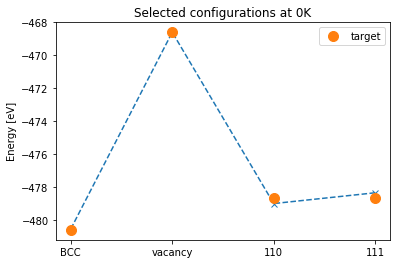

In [275]:
for i, params_uopt in enumerate(optimal_parameters[0:1]):
    opti_out, targ_out = udif_print(params_uopt, stats, target, utot_EAM)
    plt.title('Selected configurations at 0K')
    if i == len(optimal_parameters)-1:
        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized')
        plt.plot(targ_out[-1][:-1], 'o', label='target', markersize=10)
    else:
        plt.plot([o for o in opti_out[-1][:-1]], 'x--')
        plt.plot(targ_out[-1][:-1], 'o', label='target', markersize=10)

plt.xticks([0, 1, 2, 3], ['BCC','vacancy','110','111'])
plt.ylabel('Energy [eV]')
plt.legend()

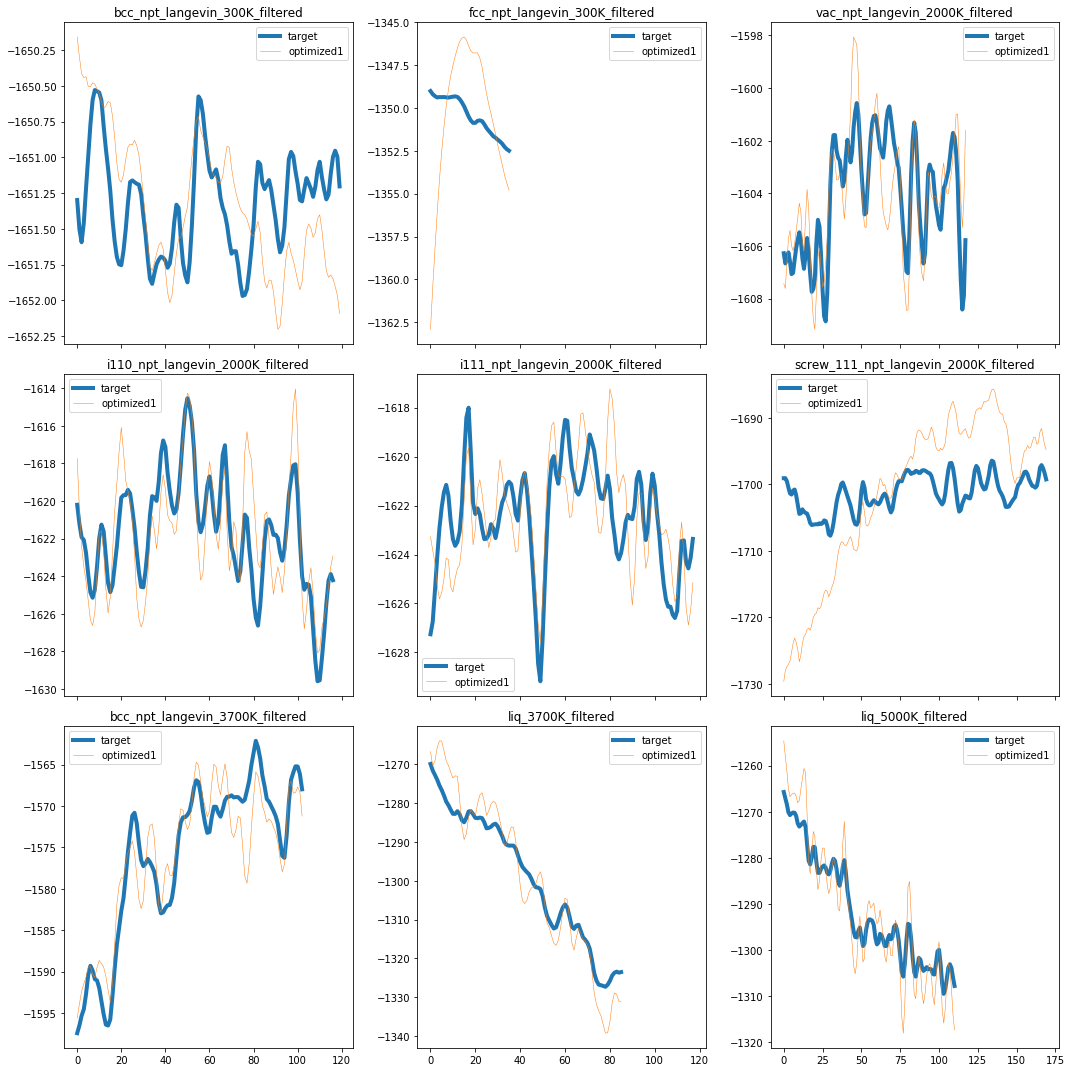

In [282]:
names = ['bcc_npt_langevin_300K_filtered',
 'fcc_npt_langevin_300K_filtered',
 'vac_npt_langevin_2000K_filtered',
 'i110_npt_langevin_2000K_filtered',
 'i111_npt_langevin_2000K_filtered',
 'screw_111_npt_langevin_2000K_filtered',
 'bcc_npt_langevin_3700K_filtered',
 'liq_3700K_filtered',
 'liq_5000K_filtered']

fig, axes = plt.subplots(3, 3, sharex='col', figsize=(15,15))

for ip, params_uopt in enumerate(optimal_parameters[:]):
    opti_out, targ_out = udif_print(params_uopt, stats, target, utot_EAM)

    for i, (tar, opt) in enumerate(zip(targ_out[:-1], opti_out[:-1])):
        x, y = divmod(i, 3)
        tar = np.array(tar)
        opt = np.array(opt)
        #print(names[i], (tar.mean() - opt.mean())/target[i]['xyz'][0].shape[0])
        opt += tar.mean() - opt.mean()
        
        if ip == 0:
            axes[x,y].plot(tar, '-', label='target', linewidth=4)
        if ip != 1:
            continue
        axes[x,y].plot(opt, '-', label='optimized'+str(ip), linewidth=0.5)

#        if ip == len(optimal_parameters)-1:
        
#            if y == 0:
#                axes[x,y].set_ylabel('Energy (eV)')
#            else:
#                axes[x,y].set_ylabel('')

#            if x == 2:
#                axes[x,y].set_xlabel('configuration #')
#            else:
#                axes[x,y].set_xlabel('')


#        else:
#            if ip == 0:
#                axes[x,y].plot(opt, '-', linewidth=3)
#            else:
#                axes[x,y].plot(opt, '-', linewidth=0.5)
                
        axes[x,y].set_title(names[i])
        axes[x,y].legend()
        
fig.tight_layout()

In [295]:
# electronic density function (cubic splines)
rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

In [296]:
# electronic density parameters
rho_re_a = [3.704045964e-3]
rho_re_r = [5.46]

# embeding function parameters
F_re_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

# pair potential
V_re_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]

In [297]:
# electronic density parameters
#rho_x_a = [3.704045964e-3]
rho_x_a = [1.0]
rho_x_r = [4.77]

# embeding function parameters
F_x_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

#3.704045964e-3

# pair potential
V_x_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_x_a = [x*2 for x in V_re_a]
#V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]
V_x_r = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
#[2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

In [298]:
def utot_re(x):
    u = 4*V(x, V_re_a, V_re_r)
    d = 8*phi(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/8

In [316]:
params_uopt1 = optimal_parameters[0]
params_uopt1

array([-1.70505735e+00, -2.74527860e-04,  1.16391099e+00,  2.97859058e+01,
       -6.68574479e-01,  2.01623180e-01,  4.63484546e-01,  3.68141435e-02])

In [327]:
params_uopt1 = np.array([-1.5423210689784401, -0.00017343233436656878, -90.79414800589194, 32.89403373260747, -3.10540157135613, 4.060736599127576, -2.1465438441937845, 0.4381050467510904])

In [345]:
#V_x_r = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]
V_x_r = [2.5, 2.75, 3.25, 3.75, 4.5, 5.5]
params_uopt1 = np.array([-2.84348049e+00, -2.76675081e-04, -1.04368940e+02,  3.27679045e+01,-3.89903767e+00,  3.10005072e+00, -9.31445199e-01,  5.39337680e-01])

In [346]:
pair_x = pars_in[2:]
many_x = [pars_in[0], 0.0, pars_in[1]]

In [347]:
pair_y = params_uopt1[2:]
many_y = [params_uopt1[0], 0.0, params_uopt1[1]]

#pair_z = params_fopt[2:]
#many_z = [params_fopt[0], 0.0, params_fopt[1]]
many_y

[-2.84348049, 0.0, -0.000276675081]

In [2]:
%%writefile -a ../../src/mkpot/wpot.f

# Cohesive potential parameters
rho_w_a = [-0.420429e1, 0.518217702, 0.5627208e-1, 0.344164179e-1]
rho_w_r = [2.5, 3.1, 3.5, 4.9]

# Embedding function parameters
F_w_a = [-5.946454, 0.0, -0.049477] # Original Marinica
Fc_w_a = [-5.524855802, 2.317313103e-1, -3.665345949e-2, 8.989367404e-3] # Bonny's correction

# Pair potential parameters
arr = np.array([
(1,  0.960851701343041e2, 2.5648975),
(2, -0.184410923895214e3, 2.6297950),
(3,  0.935784079613550e2, 2.6946925),
(4, -0.798358265041677e1, 2.8663175),
(5,  0.747034092936229e1, 2.9730450),
(6, -0.152756043708453e1, 3.0797725),
(7,  0.125205932634393e1, 3.5164725),
(8,  0.163082162159425e1, 3.8464450),
(9, -0.141854775352260e1, 4.1764175),
(10,-0.819936046256149e0, 4.7008450),
(11, 0.198013514305908e1, 4.8953000),
(12,-0.696430179520267e0, 5.0897550),
(13, 0.304546909722160e-1,5.3429525),
(14,-0.163131143161660e1, 5.4016950),
(15, 0.138409896486177e1, 5.4604375)])

V_w_a = arr[:,1]
V_w_r = arr[:,2]

Appending to ../../src/mkpot/wpot.f


In [349]:
# Gauge conversion perameters
C = 1.848055990
S = 2.232322602e-1

# Rescaled cohesive potential function
rho = lambda r: phi(r, rho_w_a, rho_w_r)*S

# Rescaled embedding function with Bonny's correction
Fe = lambda d, a: F(d/S, a) + C/S*d # rescaled potential
Fc = lambda d, a: a[0] + a[1]*d + a[2]*d**2 + a[3]*d**3 # correction
Fa = lambda d, a1, a2: Fe(d, a1) if d < 1.359141225 else Fc(d, a2) # rescaled + correction

# Rescaled pair potential function
V_pair = lambda r: 0.5*(V(r, V_w_a, V_w_r) - 2*C*rho(r)/S)

# Manybody potential for 8 NN
V_man = lambda x: Fa(rho(x)*8, F_w_a, Fc_w_a)/8
V_many = lambda d: Fa(d, F_w_a, Fc_w_a)

In [350]:
def utot_opt(x, pn, mn):
    u = 4*V(x, pn, V_x_r)
    d = 8*phi(x, rho_x_a, rho_x_r)
    u += F(d, mn)
    return u/8

In [351]:
pair_y, many_y

(array([-104.36894   ,   32.7679045 ,   -3.89903767,    3.10005072,
          -0.9314452 ,    0.53933768]), [-2.84348049, 0.0, -0.000276675081])

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Text(0,0.5,'U(r)')

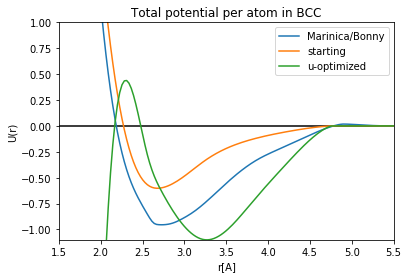

In [352]:
rcut = 5.46
rcut = 5.5
r = np.linspace(0., rcut, 201)

pot = [utot_re(x) for x in r]
pot_start = [utot_opt(x, pair_x, many_x) for x in r]
pot_uopt = [utot_opt(x, pair_y, many_y) for x in r]
plt.title('Total potential per atom in BCC')

pot_tot = [V_pair(x) + V_man(x) for x in r]

plt.plot(r, pot_tot, label='Marinica/Bonny')
plt.plot(r, pot_start, label='starting')
plt.plot(r, pot_uopt, label='u-optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
#plt.hlines(-0.89, 1.5, rcut)

plt.axis([1.5, rcut, -1.1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

2.56674843448 108.531333 363.656614418
1.60689383571 106.678515243 353.069044769
0.68181879396 104.846905608 342.690155898
-0.209292464317 103.036382016 332.517861368
-1.06724173015 101.246822388 322.550074739
-1.89281697401 99.4781046454 312.784709572
-2.68679250692 97.7301067103 303.219679429
-3.44992914055 96.0027065041 293.85289787
-4.18297434641 94.2957819481 284.682278458

In [343]:
[utot_opt(x, pair_y, many_y) for x in r]

[-493.9489032643447,
 -476.4739182929307,
 -459.4127377281277,
 -442.7602366829182,
 -426.5113004082011,
 -410.6608241750577,
 -395.20371315770853,
 -380.1348823171599,
 -365.44925628554364,
 -351.1417692511487,
 -337.2073648441415,
 -323.6409960229809,
 -310.4376249615238,
 -297.59222293682205,
 -285.0997702176111,
 -272.9552559534913,
 -261.1536780648013,
 -249.69004313318194,
 -238.5593662928345,
 -227.75667112246856,
 -217.27698953794393,
 -207.1153616856057,
 -197.26683583630896,
 -187.72646828013842,
 -178.48932322181983,
 -169.55047267682477,
 -160.90499636816682,
 -152.54798162389253,
 -144.4745232752641,
 -136.67972355563637,
 -129.15869200002572,
 -121.90654534537403,
 -114.91840743150516,
 -108.18940910277512,
 -101.71468811041697,
 -95.48938901557878,
 -89.50866309305613,
 -83.76766823571936,
 -78.26156885963434,
 -72.98553580987891,
 -67.93474626705331,
 -63.104383654486654,
 -58.48963754613714,
 -54.08570357518935,
 -49.88778334334603,
 -45.89108433081617,
 -42.0908198069

Text(0,0.5,'U')

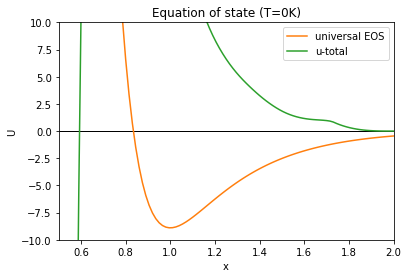

In [344]:
# Total pair potential
pos = targ_dict['dset9']['xyz'][0]
bx = targ_dict['dset9']['box'][0]
rr, rx = pair_dist_triclinic(pos, bx)

plt.hist(rr[0], 50)
#r = np.linspace(0., rcut, 201)
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        #print(z[i])
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        #print('d',a, d)
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

#ene2 = []
#for a in np.linspace(0.5, 2.0, 101):
#    z = a*rr
#    u_pair = 0.5*np.sum([V(x, pair_z, V_x_r) for x in z.flatten() if x > 0.1])

#    u_many = 0.0
#    for i in range(z.shape[0]):
        #print(z[i])
#        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
#        u_many += F(d, many_z)

#    ene2.append([a, u_pair, u_many, u_pair+u_many])
    
#print(ene)
ene = np.array(ene)
#ene2 = np.array(ene2)

#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0], [eos(x) for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0], ene[:,3]/54, label='u-total')
#plt.plot(ene2[:,0], ene2[:,3]/54, label='f-total')
plt.hlines(0.0,0.5,2.0,lw=1)
plt.legend()
plt.xlim(0.5, 2.0)
plt.ylim(-10,10)
plt.xlabel('x')
plt.ylabel(r'U')

In [98]:
# Ranges of densities and separations
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

nr = 5000
#rcut = 5.46
rcut = 4.77
dr = rcut/nr

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

In [99]:
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

# electronic density function (cubic splines)
#rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

rho = f_spline

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# pair potential function (same spline form as electronic density)
V = rho

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

In [100]:
rho_a = [1.0]
rho_r = [4.77]

pair_a = params_uopt[2:]
pair_r = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

many_a = [params_uopt[0], 0.0, params_uopt[1]]

In [101]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [104]:
r[-1], r2[-1], len(r), len(r2)

(4.7690459999999995, 4.77, 5000, 201)

In [106]:
params_uopt

array([-5.51731425e-01,  5.74575478e-04,  2.63611611e+00,  6.17016909e+01,
       -1.10762073e+00, -2.35291978e-01, -1.37604602e-01, -9.86919661e-02])

In [ ]:
-0.5517314254069565 0.0005745754784552442 2.636116105053761 61.70169091463822 -1.1076207342964204 -0.23529197754710557 -0.13760460227259147 -0.0986919660712822

In [103]:
#%%writefile ../../statmechlib/statmechlib/read_write/write_eam_yuri.py

# LAMMPS format
with open(os.path.join(pot_path, 'W_lv22.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))

In [43]:
print(os.path.join(pot_path, 'W_lv.eam.fs'))

../sim/potentials/W_lv.eam.fs


In [44]:
min(edens), max(edens)

(8.682506640003315e-10, 108.53133299999998)

In [45]:
min(fembd), max(fembd)

(-2.571752080159569, 556.9001364523145)

In [46]:
def utot_opt2(x, pn, mn):
    u = 4*V(x, pn, pair_r)
    d = 8*phi(x, rho_a, rho_r)
    u += F(d, mn)
    #print(F(d, mn), phi(x, rho_a, rho_r), V(x, pn, pair_r))
    return u/8

In [47]:
utot_x = [utot_opt2(x, pair_a, many_a) for x in r]

TypeError: <lambda>() missing 2 required positional arguments: 'aa' and 'kk'

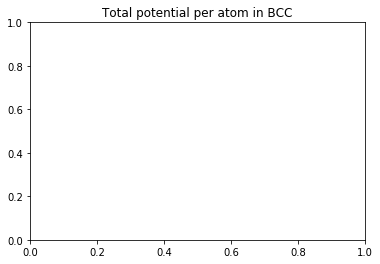

In [48]:
#rcut = 5.46
#r = np.linspace(0., rcut, 201)
r = np.linspace(0., rcut-dr, nr, endpoint=True)

pot = [utot_re(x) for x in r]
pot_start = [utot_opt(x, pair_x, many_x) for x in r]
pot_uopt = [utot_opt2(x, pair_a, many_a) for x in r]
#pot_fopt = [utot_opt(x, pair_z, many_z) for x in r]

plt.title('Total potential per atom in BCC')
pot_tot = [V_pair(x) + V_man(x) for x in r]
plt.plot(r, pot_tot, label='Marinica/Bonny')
#plt.plot(r, pot, label='original')
plt.plot(r, pot_start, label='starting')
plt.plot(r, pot_uopt, label='u-optimized')
#plt.plot(r, pot_fopt, label='f-optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
#plt.hlines(-0.89, 1.5, rcut)

plt.axis([1.5, rcut, -1.1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')